#  DSC478 - Programming Machine Learning Applications
## Assignment 2 - Lavinia Wang

### Question 1.K-Nearest-Neighbor (KNN) classification on Newsgroups

Dataset: <a href='http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/newsgroups.zip'>newsgroups.zip</a> Dataset description <a href='http://qwone.com/~jason/20Newsgroups/'>here</a>

For this problem you will use a subset of the 20 Newsgroup data set (1000 docs and a vocabulary of terms). Each document belongs to one of two classes: Hockey (label 1) and Microsoft Windows (label 0).
Data has already been split into training and testing sets (80% / 20%), and preprocessed to handle stopwords and perform stemming.
Class labels are provided in separate files. There is a row for each term in the vocabulary and a column for each document, values are raw term frequencies.
For these questions, <b>scikit-learn won't be used</b>

In [1]:
# Import Modules
import numpy as np
import pandas as pd
from os import chdir
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Change working directory
chdir('/resources/CSC478/Assignment2')

In [3]:
# Load text file
train = pd.read_table('trainMatrixModified.txt', header = None)
train_label = np.loadtxt('trainClasses.txt', usecols = 1, dtype = int)
test = pd.read_table('testMatrixModified.txt', header = None)
test_label = np.loadtxt('testClasses.txt', usecols = 1, dtype = int)

In [4]:
# Check shape
print(train.shape)
print(train_label.shape)
print(test.shape)
print(test_label.shape)

(5500, 800)
(800,)
(5500, 200)
(200,)


In [5]:
# Transpose
train_table = train.T
print(train_table.shape)
test_table = test.T
print(test_table.shape)

(800, 5500)
(200, 5500)


In [6]:
# Number of terms and docs
numTerms = train_table.shape[1]
NDocs = train_table.shape[0]
print("Number of terms: {} and number of documents: {}".format(numTerms, NDocs))

Number of terms: 5500 and number of documents: 800


In [7]:
# Sum term count across documents
termFreqs = train_table.sum(axis = 1)
print (termFreqs[:10])

0    196.0
1     79.0
2     51.0
3     39.0
4     33.0
5    245.0
6    119.0
7     55.0
8     62.0
9    219.0
dtype: float64


In [8]:
# Bring in the vocabulary of terms
terms = np.loadtxt("modifiedterms.txt", dtype = str)
terms[0:10]

array(['david', 'rex', 'wood', 'subject', 'call', 'librari', 'creat',
       'widget', 'multipl', 'time'], dtype='<U79')

In [9]:
# Create term-freqency dictionary
dictTF = {}
for i in range(len(termFreqs)):
    dictTF[terms[i]] = termFreqs[i]
#print (sorted(dictTF.items()))
sortedTF = sorted(dictTF.values(), reverse=True)

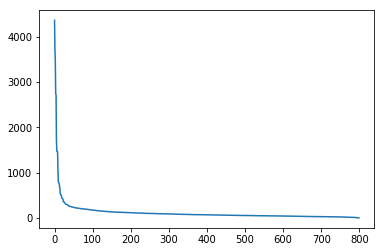

In [10]:
# Plot term frequencies
plt.plot(sortedTF)
plt.show()

In [11]:
# Convert frame to array
trainDF = np.array(train_table)
testDF = np.array(test_table)
print(trainDF.shape)
print(testDF.shape)

(800, 5500)
(200, 5500)


#### a. Create your own KNN classifier function. Your classifier should allow as input the training data matrix, the training labels, the instance to be classified, the value of K, and should return the predicted class for the instance and the top K neighbors. Your classifier should work with Euclidean distance as well as Cosine Similarity. You may create two separate classifiers, or add this capability as a parameter for the classifier function.

In [12]:
# Calculates distances between observations via euclidean metric.
def euclidean_distance(x, D):
    return np.sqrt(((D - x)**2).sum(axis=1))

# Calculates distances between observations via cosine similarity.
def cosine_similarity(x, D):
    D = np.array(D)  # make sure the data frame is consistent   
    D_norm = np.array([np.linalg.norm(D[i]) for i in range(len(D))])
    x_norm = np.linalg.norm(x)
    sims = np.dot(D,x)/(D_norm * x_norm)   
    return 1 - sims

# Define a function for kNN search
def knn_classify(x, D, L, K, measure):
    """ find K nearest neighbours of data point x among D """
    if measure == 0:
        # euclidean distances from the other points
        dists = euclidean_distance(x, D)
    elif measure == 1:
        dists = cosine_similarity(x, D)
    idx = np.argsort(dists) # sorting
    # return the indexes of K nearest neighbors
    neigh_labels = L[idx[:K]]
    class0 = 0
    class1 = 0
    for index in neigh_labels:
        if L[index] == 0:
            class0 = class0 + 1
        else:
            class1 = class1 + 1
        if class0 > class1:
            predicted_class = 0
        else:
            predicted_class = 1
    #print("The " + str(K) + " Nearest Neighbours are:" + str(idx[:K]))
    #print("The predicted class is: " + str(predicted_class))
    return idx[:K], predicted_class

In [13]:
neigh_idx, predicted_class = knn_classify(testDF[0], trainDF, train_label, 3, 1)
print("The Nearest Neighbours are:" + str(neigh_idx))
print("The predicted class is: " + str(predicted_class))

The Nearest Neighbours are:[685 628 667]
The predicted class is: 1


#### b. Create a function to compute the classification accuracy over the test data set (ratio of correct predictions to the number of test instances). This function will call the classifier function in part a on all the test instances and in each case compares the actual test class label to the predicted class label.

In [14]:
def accuracy(x, D, train_L, test_L, K, measure):
    count = 0
    correct = 0
    for i in range(x.shape[0]):
        neigh_idx, predicted_class = knn_classify(x[i,:], D, train_L, K, measure)
        #If the two classes match, add 1 to the correct count
        if (predicted_class == test_L[i]):
            correct += 1
        count += 1
    acc = (correct/count)*100
    #print("Accuracy is: " + str(accuracy) + "%")
    return acc

In [15]:
testAcc = accuracy(testDF, trainDF, train_label, test_label, 3, 0)
print("Accuracy is: " + str(testAcc) + "%")

Accuracy is: 81.0%


#### c. Run your accuracy function on a range of values for K in order to compare accuracy values for different numbers of neighbors. Do this both using Euclidean Distance as well as Cosine similarity measure. [For example, you can try evaluating your classifiers on a range of values of K from 1 through 20 and present the results as a table or a graph].

In [16]:
result = np.zeros((20,3), dtype = float)
for i in range(0, 20):
    accEuc = accuracy(testDF, trainDF, train_label, test_label, i+1, 0)
    accCos = accuracy(testDF, trainDF, train_label, test_label, i+1, 1)
    result[i] = [i+1, accEuc, accCos]
print("Results:")
print(" K  Euclid  Cosine")
for row in result:
    print("%2.0f   %.2f    %.2f" % (row[0], row[1], row[2]) )    

Results:
 K  Euclid  Cosine
 1   78.00    98.50
 2   67.50    98.00
 3   81.00    97.00
 4   77.00    98.00
 5   81.50    97.00
 6   83.50    97.50
 7   76.50    98.00
 8   80.00    97.50
 9   75.00    97.50
10   86.00    98.50
11   79.50    98.00
12   85.00    98.00
13   77.50    98.00
14   82.00    98.50
15   78.50    98.50
16   80.00    98.50
17   76.00    97.50
18   78.50    97.50
19   74.00    97.50
20   76.50    97.50


In [17]:
numK = [result[i][0] for i in range (len(result))]
Euc = [result[i][1] for i in range (len(result))]
Cos = [result[i][2] for i in range (len(result))]

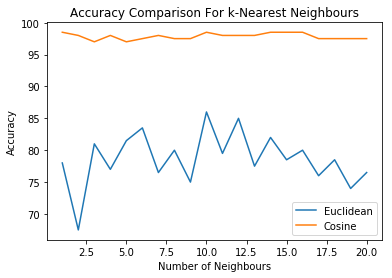

In [18]:
plt.plot(numK, Euc, label = "Euclidean")
plt.plot(numK, Cos, label = "Cosine")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison For k-Nearest Neighbours")
plt.legend(loc="best")
plt.show()

#### d. Using Python, modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies). Then, rerun your evaluation on the range of K values (as above) and compare the results to the results without using TFxIDF weights.

In [19]:
# Re-read in the training data file and labels
train1 = np.loadtxt("trainMatrixModified.txt")
train1Df = train1.T
labels = np.genfromtxt("trainClasses.txt", delimiter='\t', usecols = (1), dtype = int)
test1 = np.loadtxt("testMatrixModified.txt")
test1Df = test1.T
test_labels = np.genfromtxt("testClasses.txt", delimiter='\t', usecols = (1), dtype = int)

In [20]:
# Concatenate the df
concatData = np.concatenate((train1, test1), axis=1)

# Find document frequencies 
DF = np.array([(concatData !=0).sum(1)]).T
NDocs = len(concatData [0,:])

# Create a matrix with all entries =NDocs
NMatrix = np.ones(np.shape(concatData ), dtype=float)*NDocs
print(NMatrix)

[[1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 ...
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]
 [1000. 1000. 1000. ... 1000. 1000. 1000.]]


In [21]:
# Convert each entry into IDF values
IDF = np.log2(np.divide(NMatrix, DF))

# Compute the TF x iDF values for each document term
TD_tfidf = concatData  * IDF

# Transpose the data
DT_tfidf = TD_tfidf.T
trainNum = 0.8 * len(DT_tfidf)
trainDT_tfidf = DT_tfidf[:int(trainNum),:]
testDT_tfidf = DT_tfidf[int(trainNum):,:]

In [22]:
# Repeat the results printing like before
result2 = np.zeros((20,3), dtype = float)
for i in range(0, 20):
    accEuc = accuracy(testDT_tfidf, trainDT_tfidf, labels, test_labels, i+1, 0)
    accCos = accuracy(testDT_tfidf, trainDT_tfidf, labels, test_labels, i+1, 1)
    result2[i] = [i+1, accEuc, accCos]
print("Results:")
print(" K  Euclid  Cosine")
for row in result2:
    print("%2.0f   %.2f    %.2f" % (row[0], row[1], row[2]) )    

Results:
 K  Euclid  Cosine
 1   72.00    95.00
 2   60.50    94.50
 3   74.00    97.50
 4   62.00    96.00
 5   80.50    97.00
 6   83.50    97.00
 7   73.00    98.50
 8   74.00    98.50
 9   69.00    99.00
10   74.50    97.50
11   68.00    99.00
12   71.00    99.00
13   65.00    99.00
14   68.00    99.00
15   60.50    99.00
16   64.00    99.00
17   59.00    99.50
18   67.50    99.50
19   63.00    99.50
20   66.50    99.50


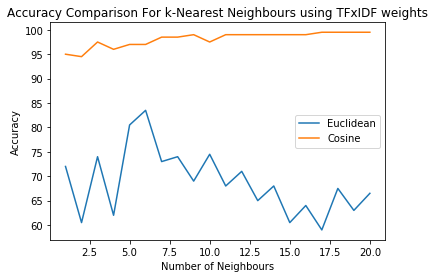

In [23]:
numK2 = [result2[i][0] for i in range (len(result2))]
Euc2 = [result2[i][1] for i in range (len(result2))]
Cos2 = [result2[i][2] for i in range (len(result2))]
plt.plot(numK2, Euc2, label = "Euclidean")
plt.plot(numK2, Cos2, label = "Cosine")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison For k-Nearest Neighbours using TFxIDF weights")
plt.legend(loc="best")
plt.show()

<b>KNN classifier using cosine similarity gives a better accuracy compared to Euclidean distance. The result from original dataset gives a better accuracy compared to TFxIDF. The result from TFxIDF shows a linear relationship between number of K and accuracy. 